# 1. Exploratory data analysis

## 1.0.1 Setup

In [1]:
import nltk
import calendar
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from gensim import models
import matplotlib.pyplot as plt
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell

In [2]:
pd.options.mode.chained_assignment = None
InteractiveShell.ast_node_interactivity = 'all'
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

## 1.0.2 Loading data and first impressions

In [3]:
columns, articles = ['category', 'headline', 'authors', 'link', 'short_description', 'date'], []

for obs in open('News_Category_Dataset_v2.json', 'r').read()[1:-1].split('}\n{'):
    articles.append([obs.split(prop + '": "')[1].split('"')[0] for prop in columns])
    
df = pd.DataFrame.from_records(articles, columns = columns)

print('There are', df.shape[0], 'rows,', df.shape[1], 'columns,',
     df.category.nunique(), 'categories and', df.isna().sum().sum(), 'NaNs.')

df.to_csv('dataframe_raw.temp.csv')

There are 200853 rows, 6 columns, 41 categories and 0 NaNs.


## 1.1 Analysis of Categories

### 1.1.1 Static Analysis

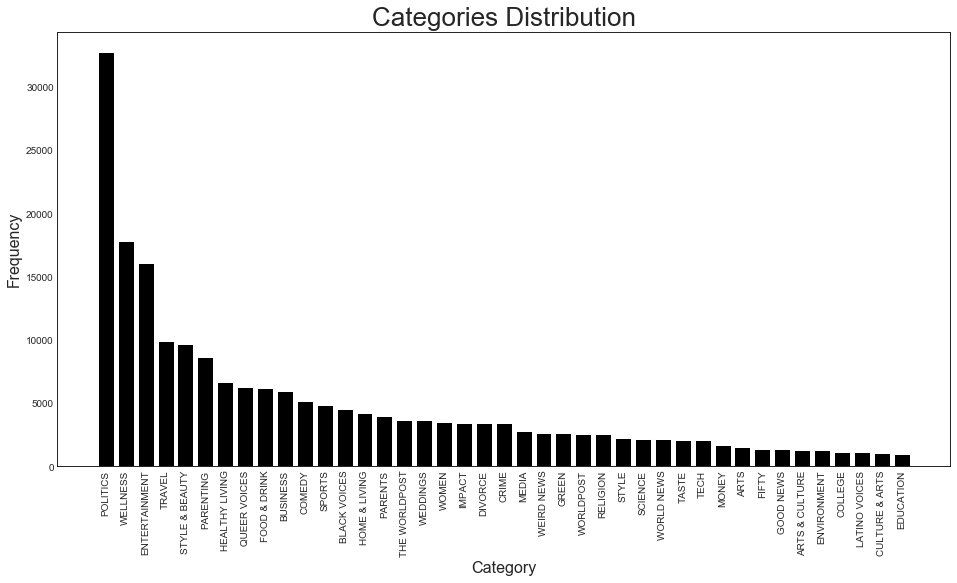

In [4]:
categories_cnt = list(Counter(df.category).most_common())

plt.figure(figsize = (16, 8));
plt.bar([cat[0] for cat in categories_cnt], [cat[1] for cat in categories_cnt], color = 'black');
plt.xticks(rotation = 90);
plt.title('Categories Distribution', fontsize = 26);
plt.xlabel('Category', fontsize = 16);
plt.ylabel('Frequency', fontsize = 16);

### 1.1.2 Temporal analysis

In [5]:
working_copy = df.copy()
working_copy['date'] = pd.to_datetime(df['date'])
working_copy['month'] = pd.DatetimeIndex(df['date']).month
working_copy['year'] = pd.DatetimeIndex(df['date']).year
working_copy['year_month'] = round(working_copy['year'] + working_copy['month'] / 12, 2)

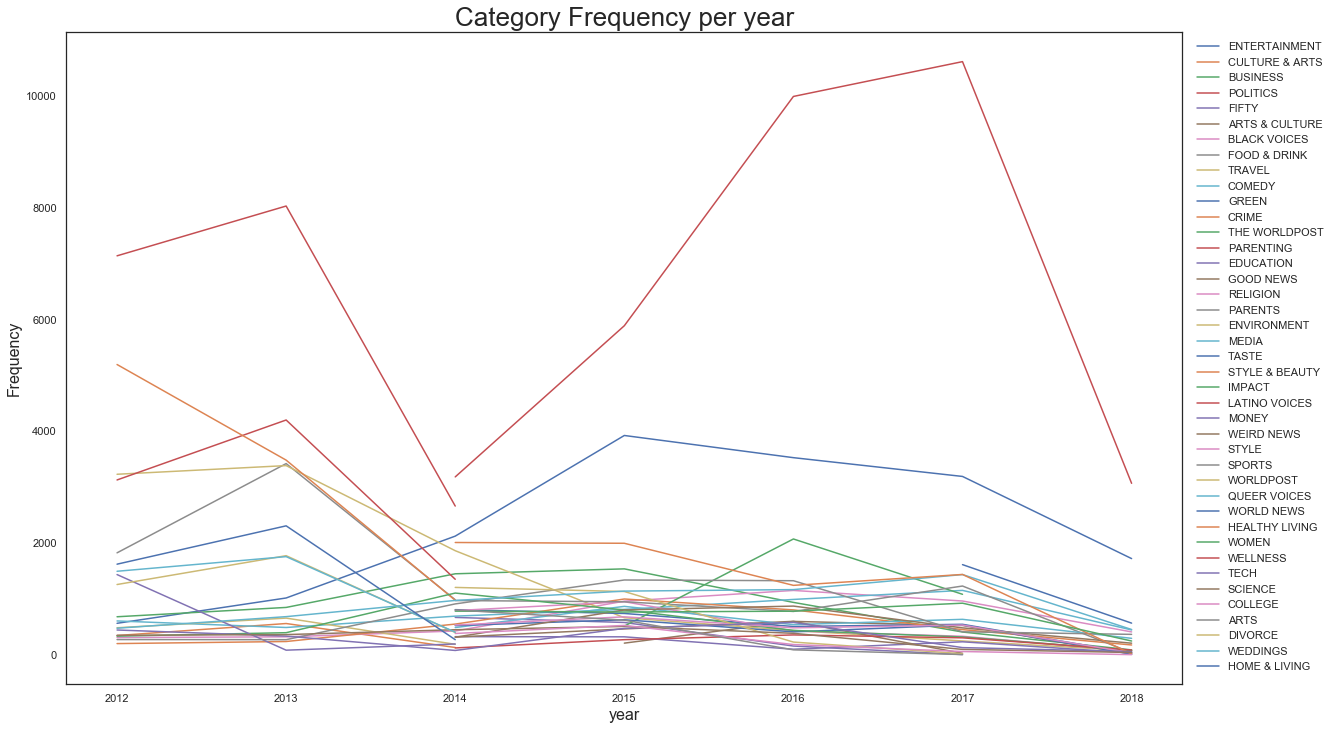

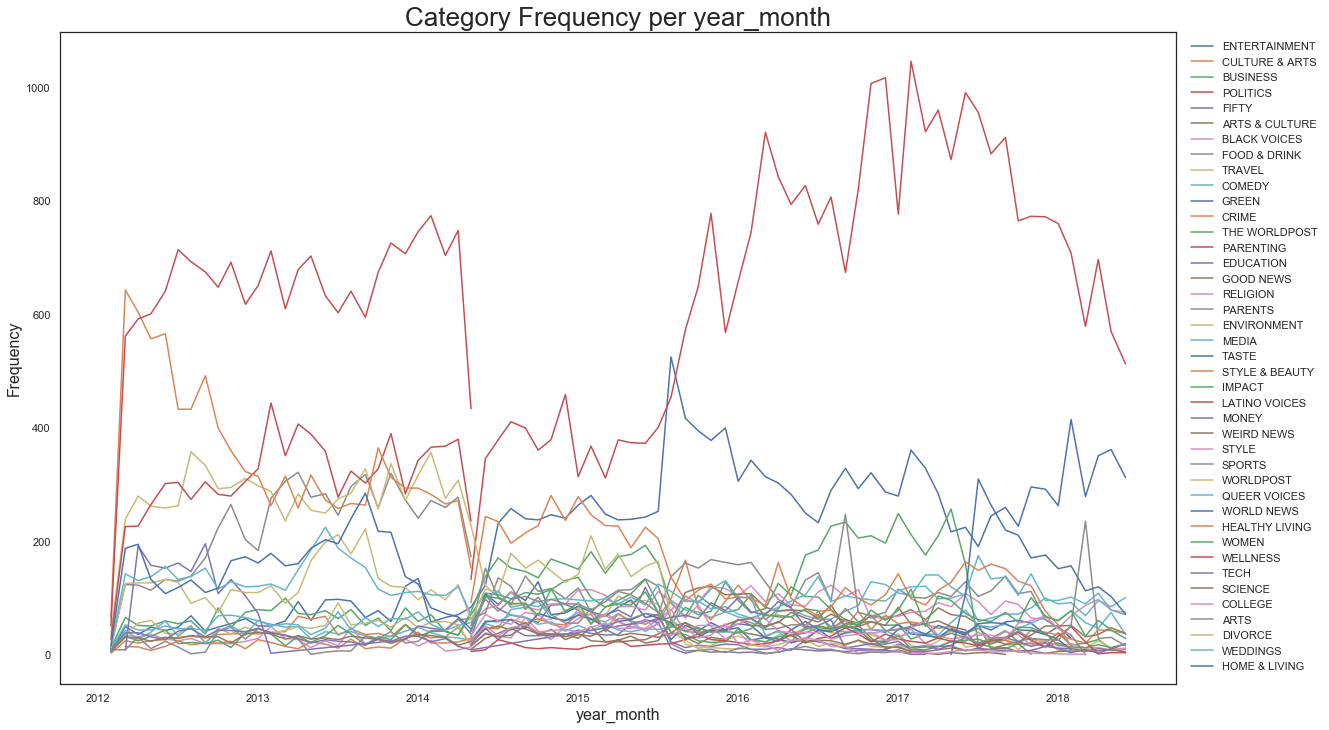

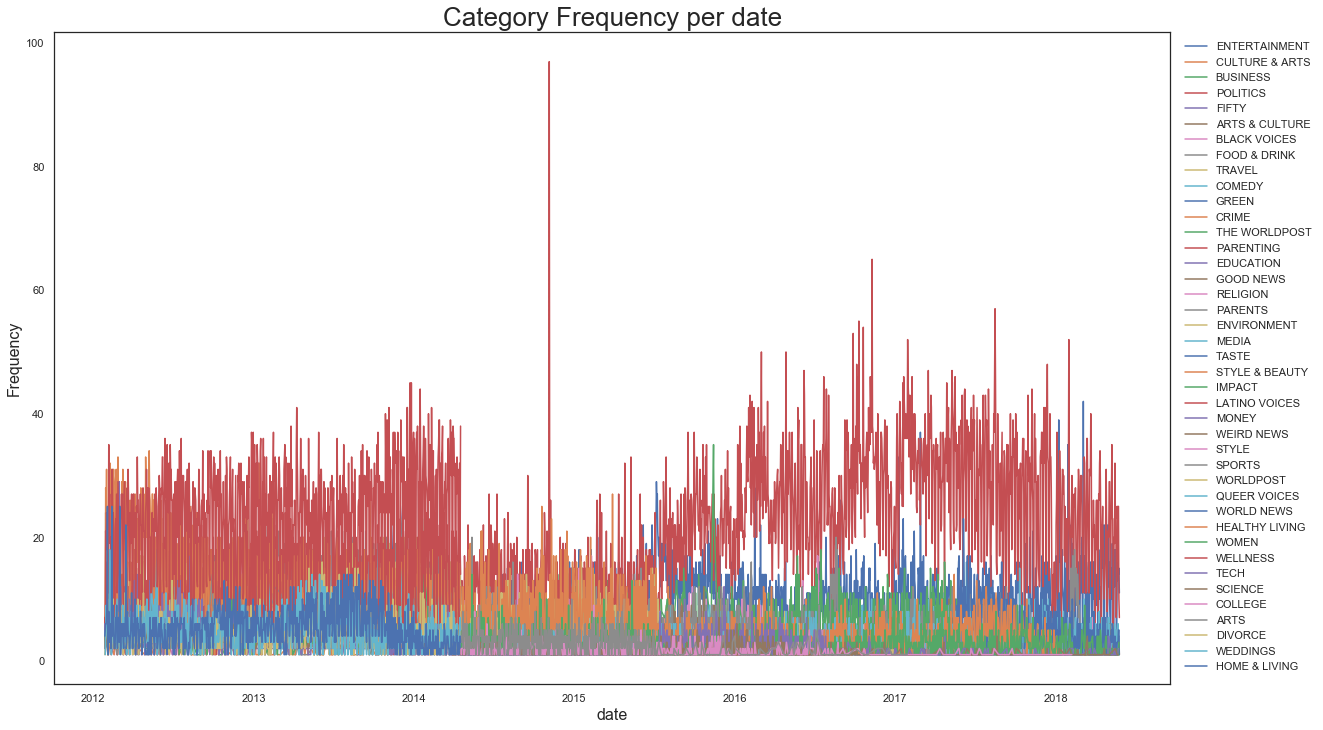

In [6]:
for time in ['year', 'year_month', 'date']:
    aggregated_df = working_copy.groupby(['category', time]).size().to_frame()
    plottable_df = aggregated_df.reset_index(level = [time, 'category'])

    sns.set(rc = {'figure.figsize':(20, 12)}, style = 'white')
    for category in list(set(df.category)):
        _ = sns.lineplot(plottable_df[plottable_df['category'] == category][time],
                         plottable_df[plottable_df['category'] == category][0]);
    _ = plt.title('Category Frequency per ' + time, fontsize = 26);
    _ = plt.xlabel(time, fontsize = 16);
    _ = plt.ylabel('Frequency', fontsize = 16);
    _ = plt.legend(
        labels = list(set(df.category)), loc = 'upper center', bbox_to_anchor = (1.07, 1)
    );
    plt.show();

In [7]:
nr_new_cat = Counter(working_copy.groupby(['category']).year_month.min()).most_common()[1]
nr_abandoned_cat = Counter(working_copy.groupby(['category']).year_month.max()).most_common()[1]
print('In', calendar.month_name[round(divmod(nr_new_cat[0], 1)[1] * 12)], \
      str(round(divmod(nr_abandoned_cat[0], 1)[0])) + ',', nr_abandoned_cat[1], \
      'categories were abandoned and', nr_new_cat[1], 'new ones were introduced.')

In April 2014, 10 categories were abandoned and 17 new ones were introduced.


In [8]:
politics_observations = working_copy[working_copy['category'] == 'POLITICS']
politics_frequencies = politics_observations.groupby(['date']).size().sort_values(ascending = False)
outlier_value, outlier_date = list(zip(politics_frequencies, politics_frequencies.index))[0]
average_value = round(np.mean(politics_frequencies))
print('On average,', average_value, "'POLITICS' articles are published per day.",
      'On', str(outlier_date)[:10] + ', there were', str(outlier_value) + '.')

On average, 22 'POLITICS' articles are published per day. On 2014-11-05, there were 97.


## 1.2 Analysis of Words

### 1.2.1 Static Analysis

In [9]:
words_counter = Counter(' '.join(df.headline).split(' ')).most_common()
total_words = sum([entry[1] for entry in words_counter])
words_share = [(word[0], word[1] / total_words) for word in words_counter]

cumulative_shares = []
for threshold in [10 ** i for i in list(range(6))]:
    share_top = sum([word[1] for word in words_share][:threshold])
    cumulative_shares.append((threshold, round(share_top * 100)))

pd.DataFrame({'n most common words' : [tup[0] for tup in cumulative_shares],
              'cumulative share' : [tup[1] for tup in cumulative_shares]})

,n most common words,cumulative share
0,1,2
1,10,12
2,100,32
3,1000,58
4,10000,86
5,100000,99


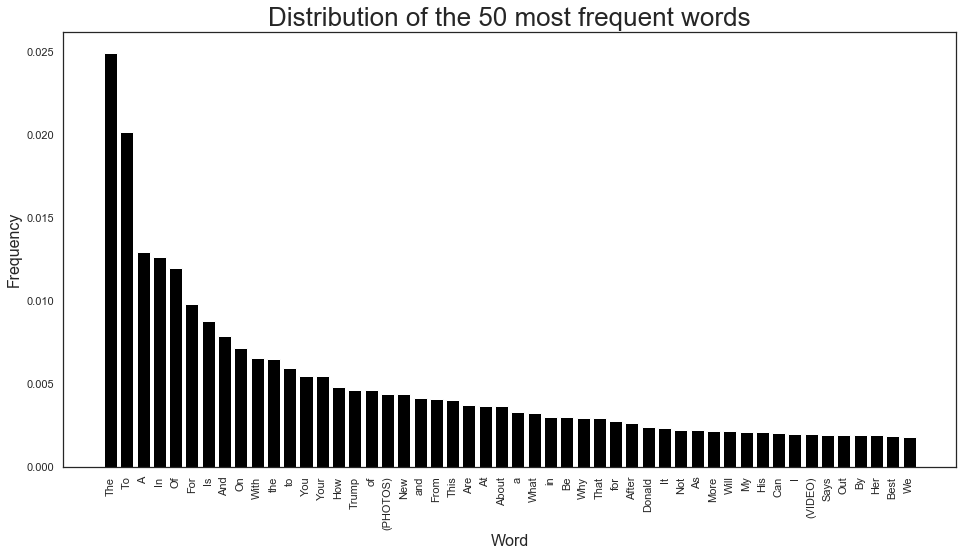

In [10]:
plt.figure(figsize = (16, 8));
plt.bar([word[0] for word in words_share[:50]],
        [word[1] for word in words_share[:50]], color = 'black');
plt.xticks(rotation = 90);
plt.title('Distribution of the 50 most frequent words', fontsize = 26);
plt.xlabel('Word', fontsize = 16);
plt.ylabel('Frequency', fontsize = 16);

In [11]:
most_common_english_words_dict = nltk.FreqDist(nltk.corpus.brown.words()).most_common()[:1000]
most_common_english_words_list = [word[0] for word in most_common_english_words_dict]

most_common_english_words_list_capitalized = [
    word.capitalize() for word in most_common_english_words_list
]

all_common_words = set(
    most_common_english_words_list +
    most_common_english_words_list_capitalized
)

words_share_without_common_words = [tup for tup in list(words_share) if tup[0] not in all_common_words]

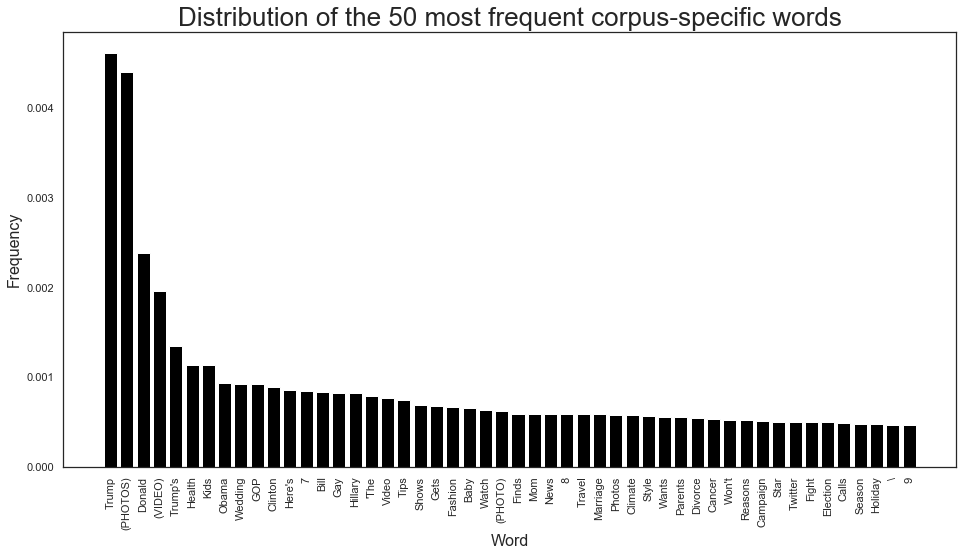

In [12]:
plt.figure(figsize = (16, 8));
plt.bar([word[0] for word in words_share_without_common_words[:50]],
        [word[1] for word in words_share_without_common_words[:50]], color = 'black');
plt.xticks(rotation = 90);
plt.title('Distribution of the 50 most frequent corpus-specific words', fontsize = 26);
plt.xlabel('Word', fontsize = 16);
plt.ylabel('Frequency', fontsize = 16);

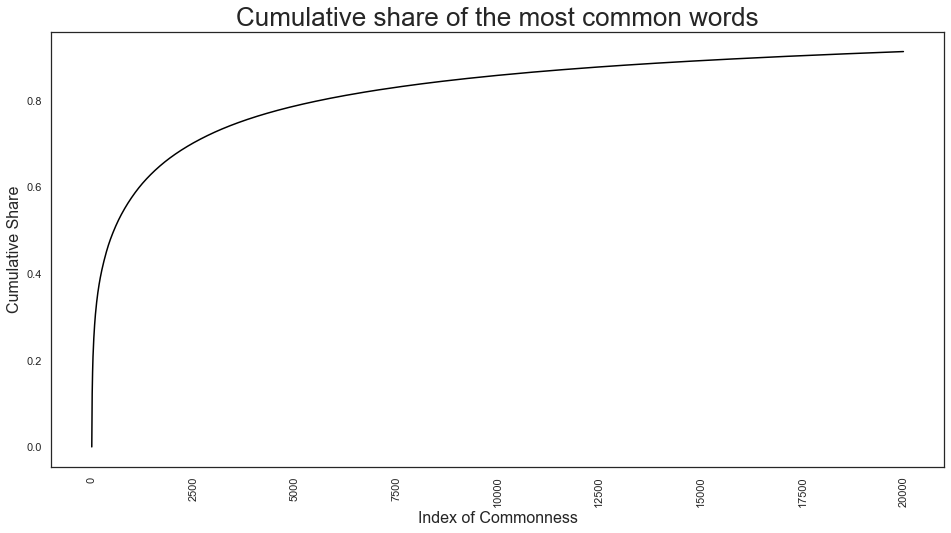

In [13]:
share_values = [sum([threshold[1] for threshold in words_share][:threshold]) \
                    for threshold in np.arange(0, total_words, 10)[:2000]]

plt.figure(figsize = (16, 8));
plt.plot([e[0] * 10 for e in enumerate(share_values)], share_values, color = 'black');
plt.title('Cumulative share of the most common words', fontsize = 26);
plt.xlabel('Index of Commonness', fontsize = 16);
plt.ylabel('Cumulative Share', fontsize = 16);
plt.xticks(rotation = 90);
plt.show();

In [14]:
categories_frequencies = df.groupby(['category']).size().sort_values(ascending = False)

most_observations, biggest_category = list(zip(
    categories_frequencies, categories_frequencies.index
))[0]

least_observations, smallest_category = list(zip(
    categories_frequencies, categories_frequencies.index
))[-1]

observations_difference = round(most_observations / least_observations)

In [15]:
relative_frequencies = {}
for category in set(df.category):
    words = ' '.join(df[df.category == category].headline).split(' ')
    counter = Counter(words).most_common()
    shares = [(word[1] / len(words)) for word in counter]
    relative_frequencies[category] = list(zip([e[0] for e in counter], shares))
    
words_difference = \
    round(max([len(value) for value in relative_frequencies.values()])/\
          min([len(value) for value in relative_frequencies.values()]))

print('The biggest category,', biggest_category + ', has ca.', observations_difference, \
      'times more observations than the smallest category,', smallest_category + \
      ', but only about', words_difference, 'times more unique words.')

The biggest category, POLITICS, has ca. 33 times more observations than the smallest category, EDUCATION, but only about 10 times more unique words.


### 1.2.2 Temporal Analysis

In [16]:
all_words = np.asarray([word[0] for word in words_counter])

words_without_timestamp = np.asarray(
    [headline.split() for headline in working_copy.headline]
)

timestamp = np.asarray(working_copy.year_month)
words_with_timestamp = list(zip(words_without_timestamp, timestamp))

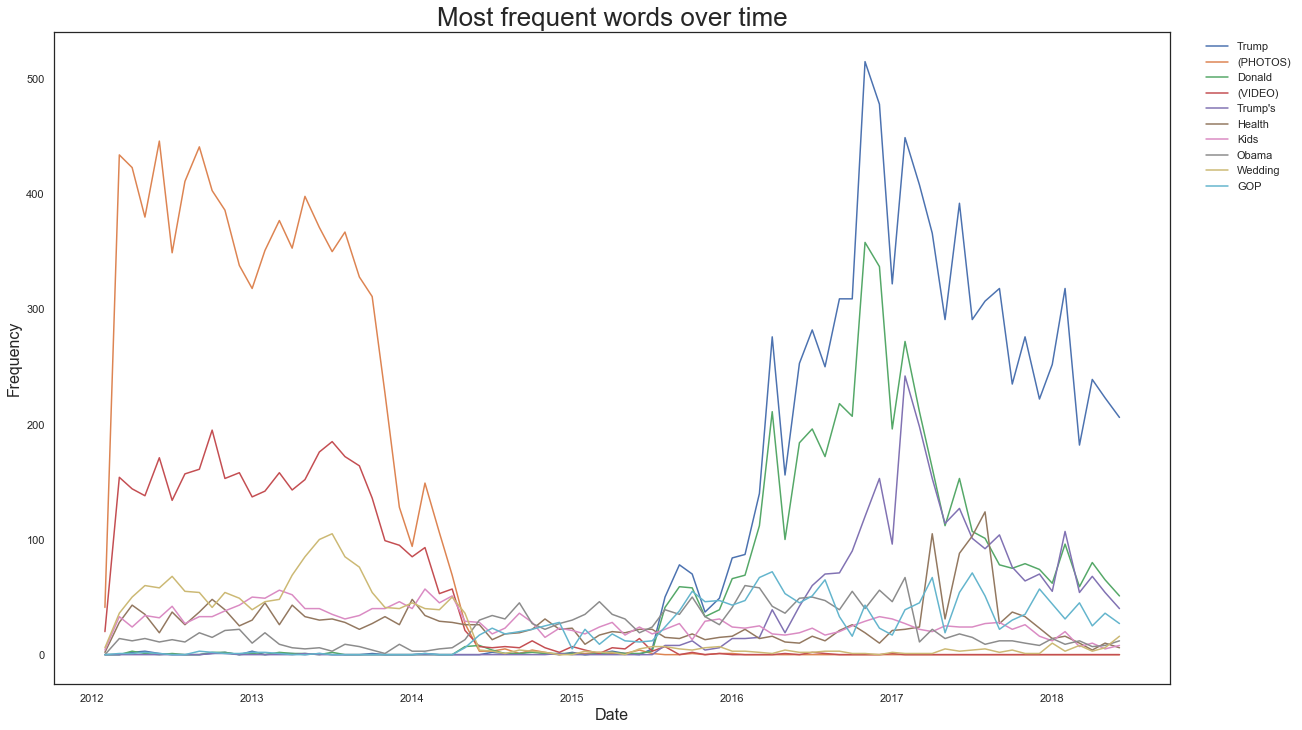

In [17]:
for word in [entry[0] for entry in words_share_without_common_words[:10]]:
    timestamps_dict = dict([(date, 0) for date in np.copy(timestamp)])

    for tup in words_with_timestamp:
        if word in tup[0]:
            timestamps_dict[tup[1]] += 1

    timestamps_list = list(timestamps_dict.items())
    
    sns.lineplot([word[0] for word in timestamps_list], [word[1] for word in timestamps_list])

_ = plt.title('Most frequent words over time', fontsize = 26);
_ = plt.xlabel('Date', fontsize = 16);
_ = plt.ylabel('Frequency', fontsize = 16);
_ = plt.legend(labels = [entry[0] for entry in words_share_without_common_words[:15]],
               loc = 'upper center', bbox_to_anchor = (1.07, 1));
plt.show();

In [18]:
all_words = list(itertools.chain(*[text.split(' ') for text in working_copy['headline']]))
vocab, vocab_list, vocab_size, total_words = \
    set(all_words), list(set(all_words)), len(set(all_words)), len(all_words)
dictionary = dict([(y,x) for x,y in enumerate(vocab)])

In [19]:
grouped_by_month_year = working_copy.groupby(['year_month'])
word_frequency_by_month_year = pd.DataFrame()

for name, group in grouped_by_month_year:
    words_counted = np.zeros(vocab_size)
    for headline in group['headline']:
        for word in headline.split(' '):
            words_counted[dictionary[word]] += 1
    
    word_frequency_by_month_year[name]  = words_counted

In [20]:
word_variance, word_freq = np.zeros(vocab_size), np.zeros(vocab_size)

for index, row in word_frequency_by_month_year.iterrows():
    trimmed = row.values[1:len(row.values)]
    word_variance[index] = np.std(trimmed)
    word_freq[index] = trimmed.sum()

In [21]:
word_score = word_variance - 0.03 * word_freq
score_sort_indices = np.argsort(word_score)[::-1]

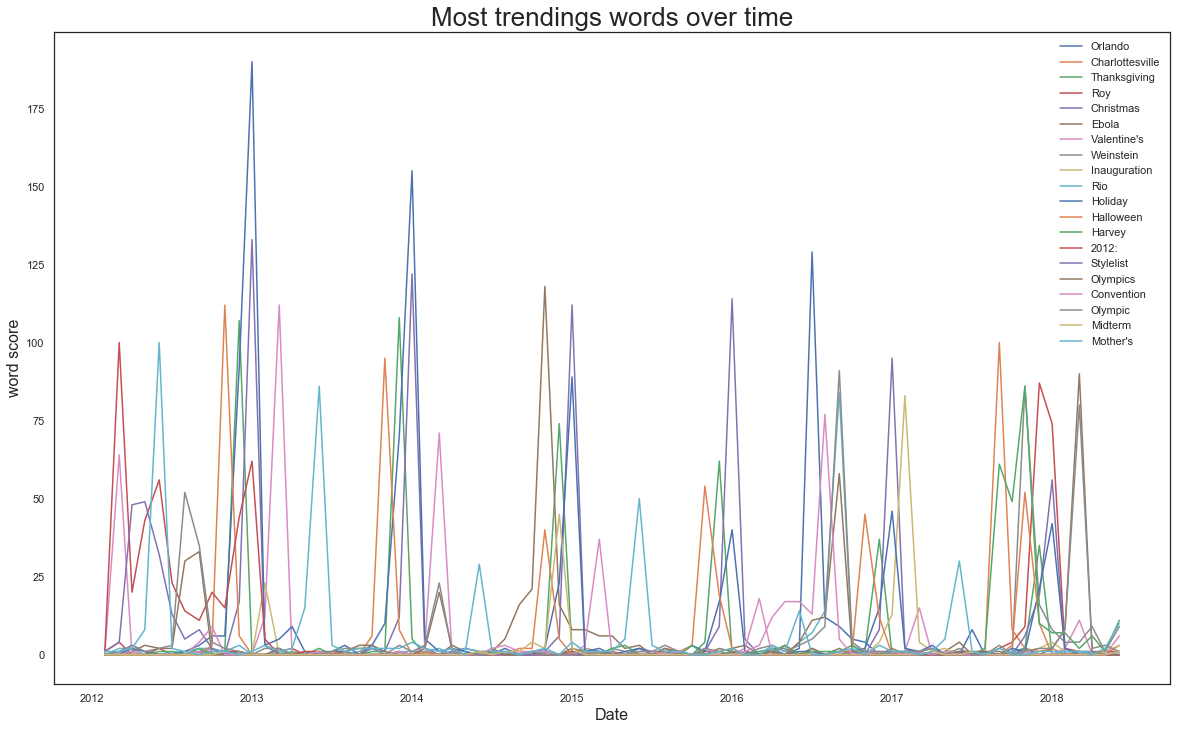

In [22]:
for index in score_sort_indices[0:20]:
    _ = sns.lineplot(word_frequency_by_month_year.columns.values,
                     word_frequency_by_month_year.iloc[index,:].values,
                     palette = sns.color_palette("cubehelix", 8))
    
_ = plt.title('Most trendings words over time', fontsize = 26);
_ = plt.legend([vocab_list[score_sort_indices[i]] for i in range(20)]);
_ = plt.xlabel('Date', fontsize = 16);
_ = plt.ylabel('word score', fontsize = 16);

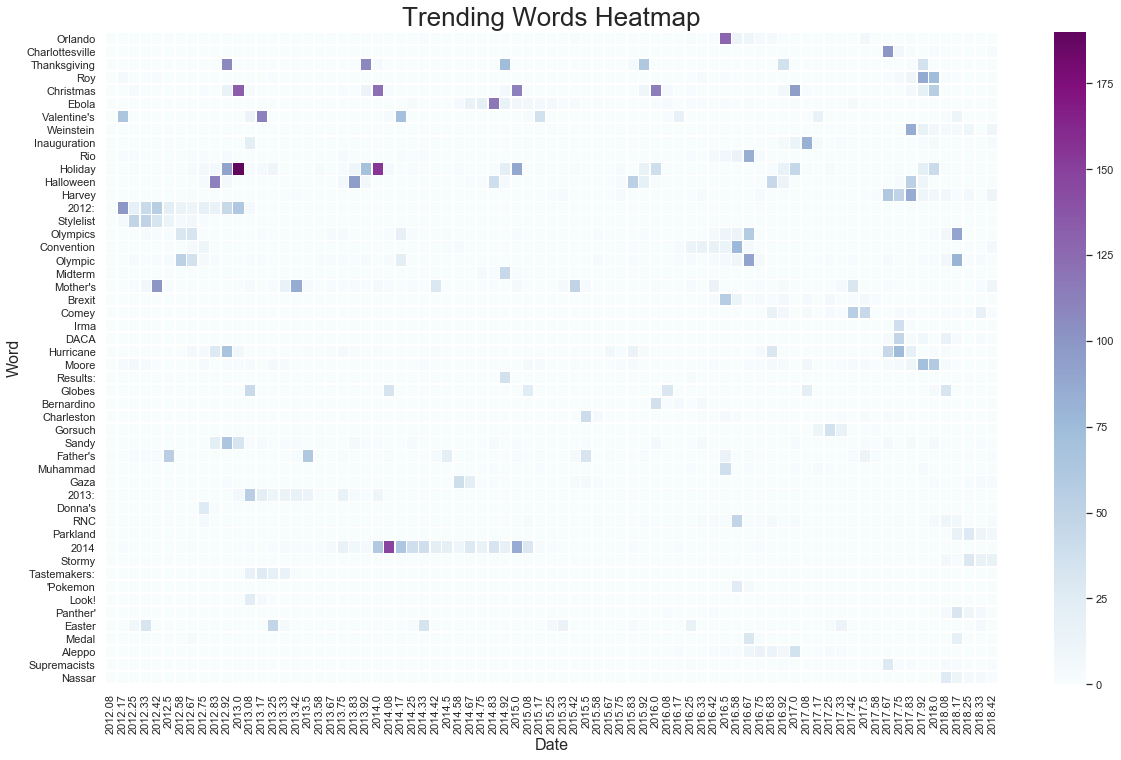

In [23]:
vocab_array = np.array(vocab_list)

g = sns.heatmap(
    word_frequency_by_month_year.iloc[score_sort_indices[0:50]],
    center= 100, cmap = "BuPu",linewidths = 0.5
)

a = g.set_yticklabels(vocab_array[score_sort_indices][0:50])
_ = plt.title('Trending Words Heatmap', fontsize = 26);
_ = plt.xlabel('Date', fontsize = 16);
_ = plt.ylabel('Word', fontsize = 16);

In [24]:
holidays = ['Thanksgiving', 'Christmas', "Valentine's", "Father's", "Halloween", "Mother's"]
holidays_indices = [dictionary[holiday] for holiday in holidays]

politics = ['Socialist', 'Liberal', 'Supremacist', 'Hate', 'Divided', 'Racist']
politics_indices = [dictionary[word] for word in politics]

opposites = ['Love', 'Good', 'Peace', 'Hate', 'Bad', 'War']
opposites_indices = [dictionary[word] for word in opposites]

internet = ['Internet', 'Digital', 'Computer', 'Online', 'Video', 'Technology']
internet_indices = [dictionary[word] for word in internet]

In [30]:
topic_words = [
    ('Holiday', holidays, holidays_indices),
    ('Politics', politics, politics_indices),
    ('Opposite', opposites, opposites_indices),
    ('Internet', internet, internet_indices),
]

In [31]:
word_frequency_by_year = pd.DataFrame()
total_words_by_year = {}
for index, col in word_frequency_by_month_year.iteritems():    
    if (str(str(index).split('.')[0]) in word_frequency_by_year):
        word_frequency_by_year[str(str(index).split('.')[0])] += col
        total_words_by_year[str(str(index).split('.')[0])] += np.sum(col.values)
    else:
        word_frequency_by_year[str(str(index).split('.')[0])] = col
        total_words_by_year[str(str(index).split('.')[0])] = np.sum(col.values)

total_words_by_year = np.fromiter(total_words_by_year.values(), dtype=float)        

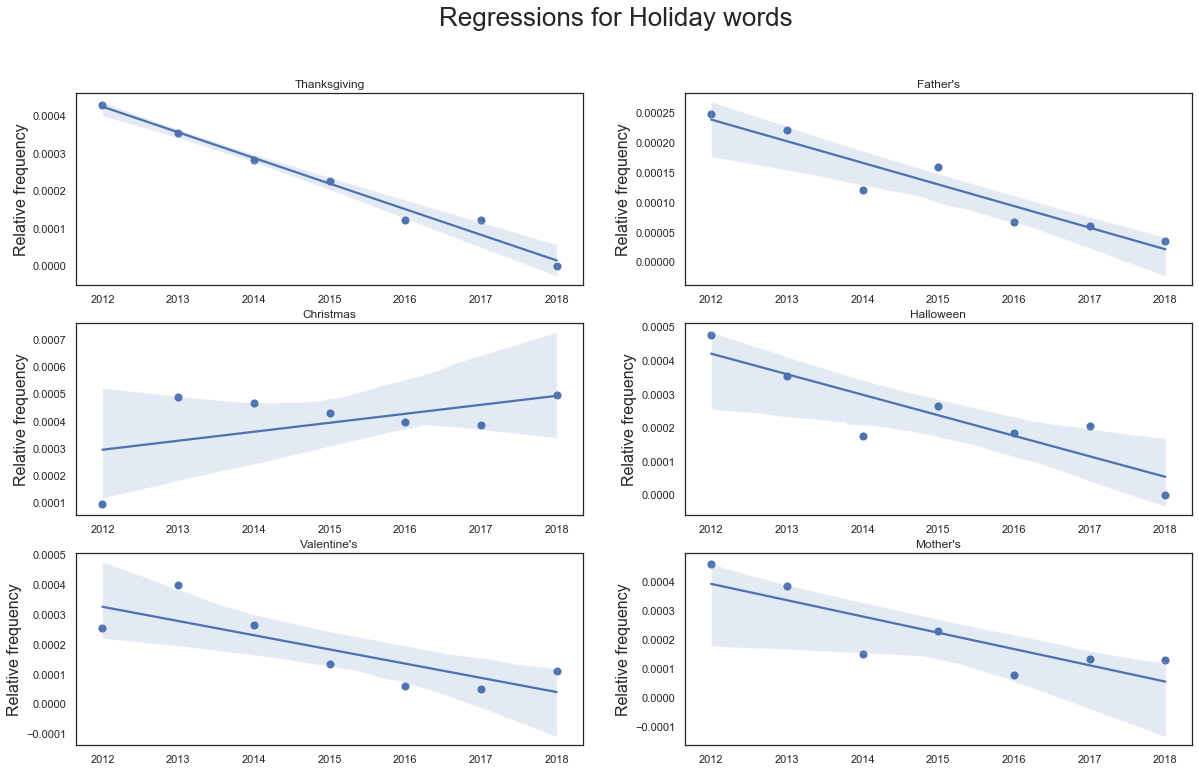

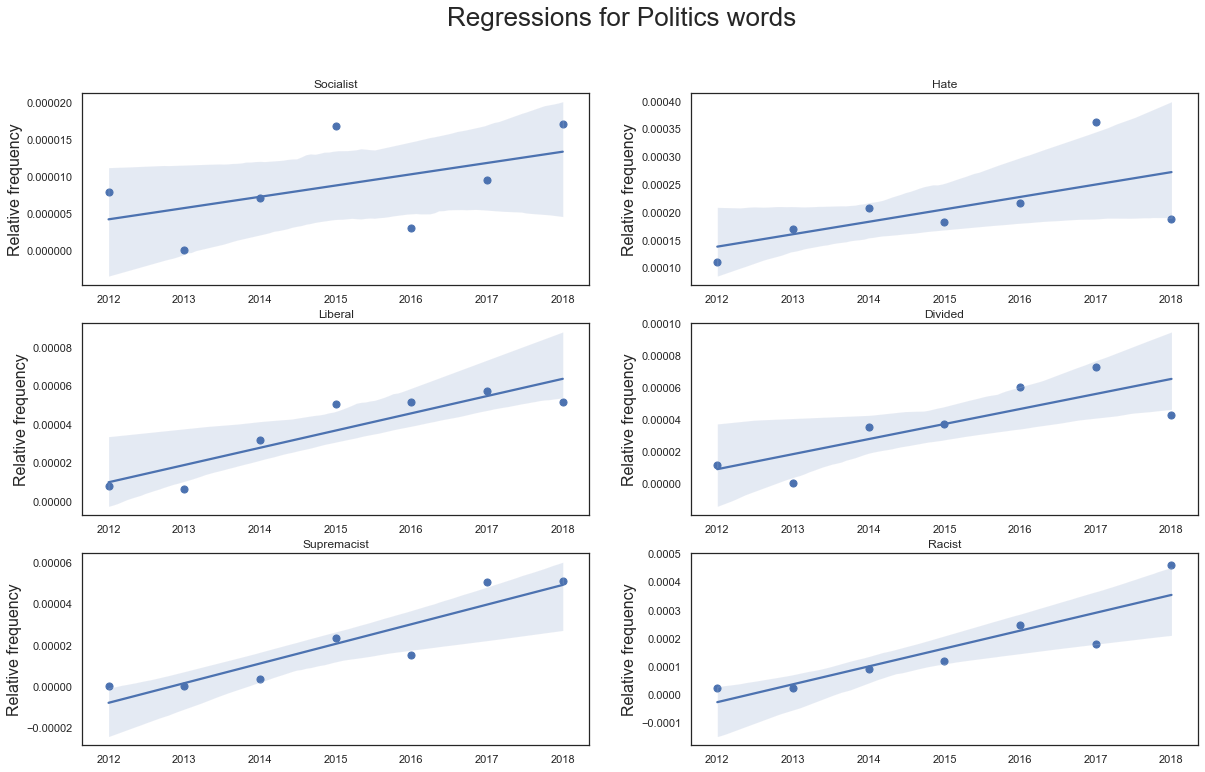

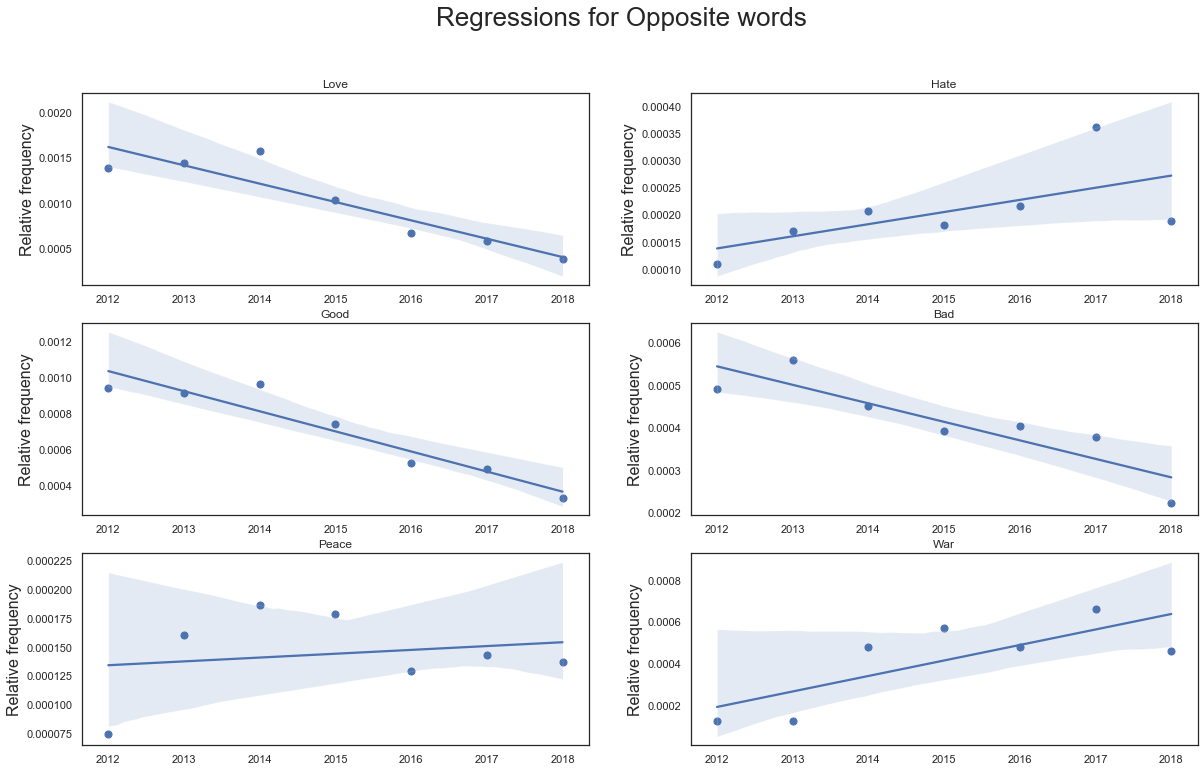

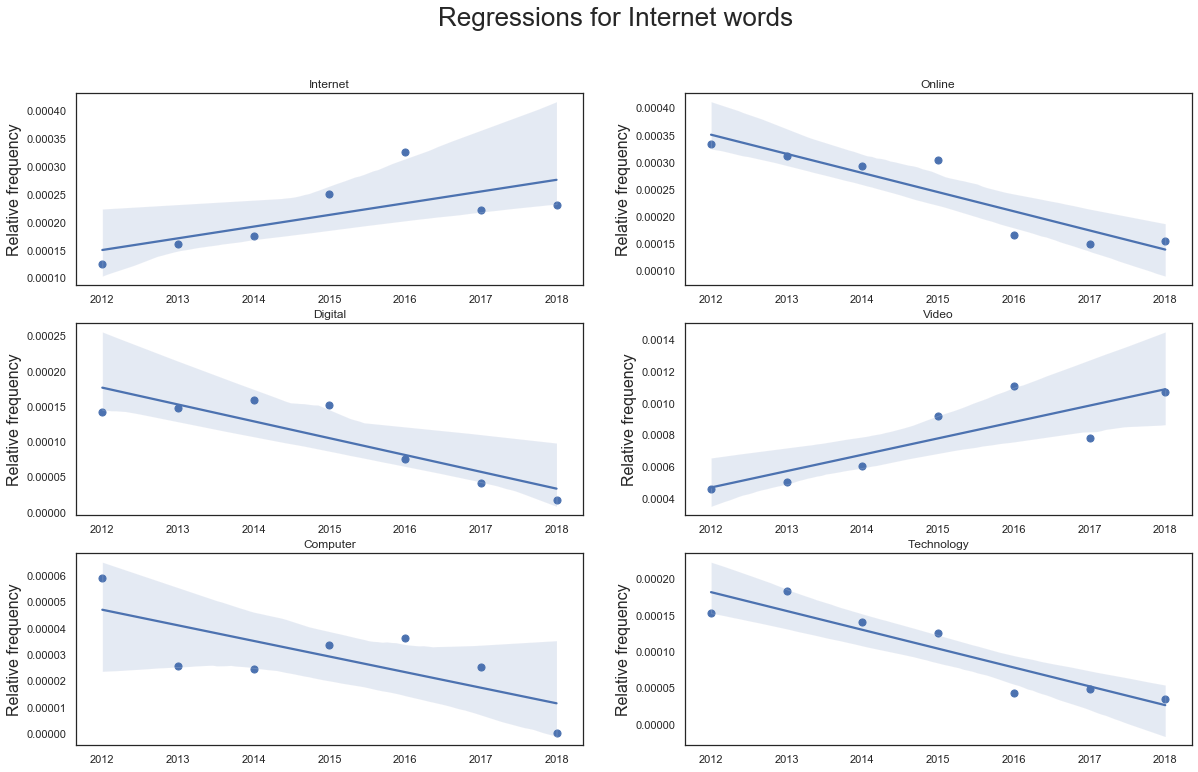

In [32]:
for triplet in topic_words:
    f, axes = plt.subplots(3, 2)
    _ = f.suptitle('Regressions for ' + triplet[0] + ' words', fontsize = 26);
    for i in range(3):
        for j in range(2):
            _ = sns.regplot(
                y = np.divide(
                    word_frequency_by_year.iloc[triplet[2][i + (j * 3)]],
                    total_words_by_year
                ), 
                x = list(np.arange(2012, 2019)), x_estimator = np.mean, ax = axes[i][j]
            );

            _ = axes[i][j].set_ylabel('Relative frequency', fontsize = 16);
            _ = axes[i][j].set_title(triplet[1][i + (j * 3)])
    plt.show();

## 1.2.1 Headline and Description Lengths

In [33]:
headline_word_counts = df['headline'].copy().apply(lambda x: len(x.split(' ')))
description_word_counts = df['short_description'].copy().apply(lambda x: len(x.split(' ')))
lenghts_and_counts = {'Headline Word Counts' : headline_word_counts,
                      'Description Word Counts' : description_word_counts}

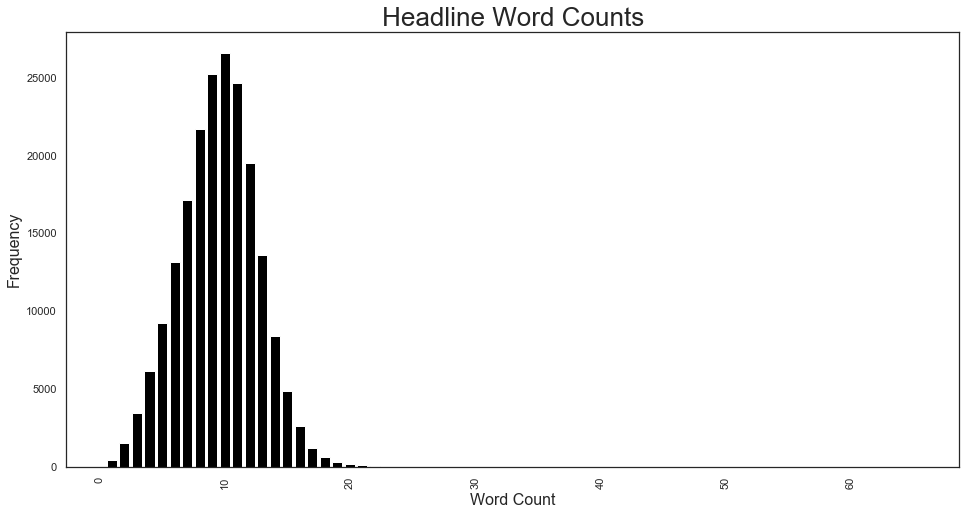

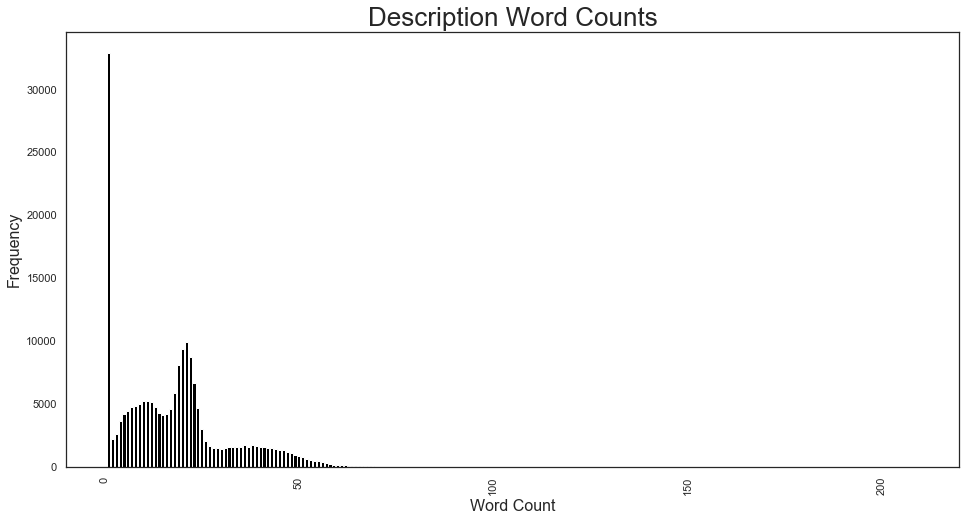

In [34]:
for measure, values in lenghts_and_counts.items():
    count = list(Counter(values).most_common())

    _ = plt.figure(figsize = (16, 8));
    _ = plt.bar([obs[0] for obs in count], [obs[1] for obs in count], color = 'black');
    _ = plt.xticks(rotation = 90);
    _ = plt.title(measure, fontsize = 26);
    _ = plt.xlabel('Word Count', fontsize = 16);
    _ = plt.ylabel('Frequency', fontsize = 16);
    plt.show();

In [35]:
counts_d = [entry[1] for entry in sorted(
    Counter(description_word_counts).most_common(), key = lambda x: x[0]
)[:50]]

local_minima = []
for i in range(2, len(counts_d) - 2):
    if counts_d[i - 1] > counts_d[i] < counts_d[i + 1]:
        if counts_d[i - 2] > counts_d[i] < counts_d[i + 2]:
            local_minima.append(i)

In [36]:
first_spike_indices, second_spike_indices, third_spike_indices = [], [], []

for e in range(len(description_word_counts)):
    if description_word_counts[e] > 1:
        if description_word_counts[e] < local_minima[0]: first_spike_indices.append(e)
        elif description_word_counts[e] < local_minima[1]: second_spike_indices.append(e)
        else: third_spike_indices.append(e)

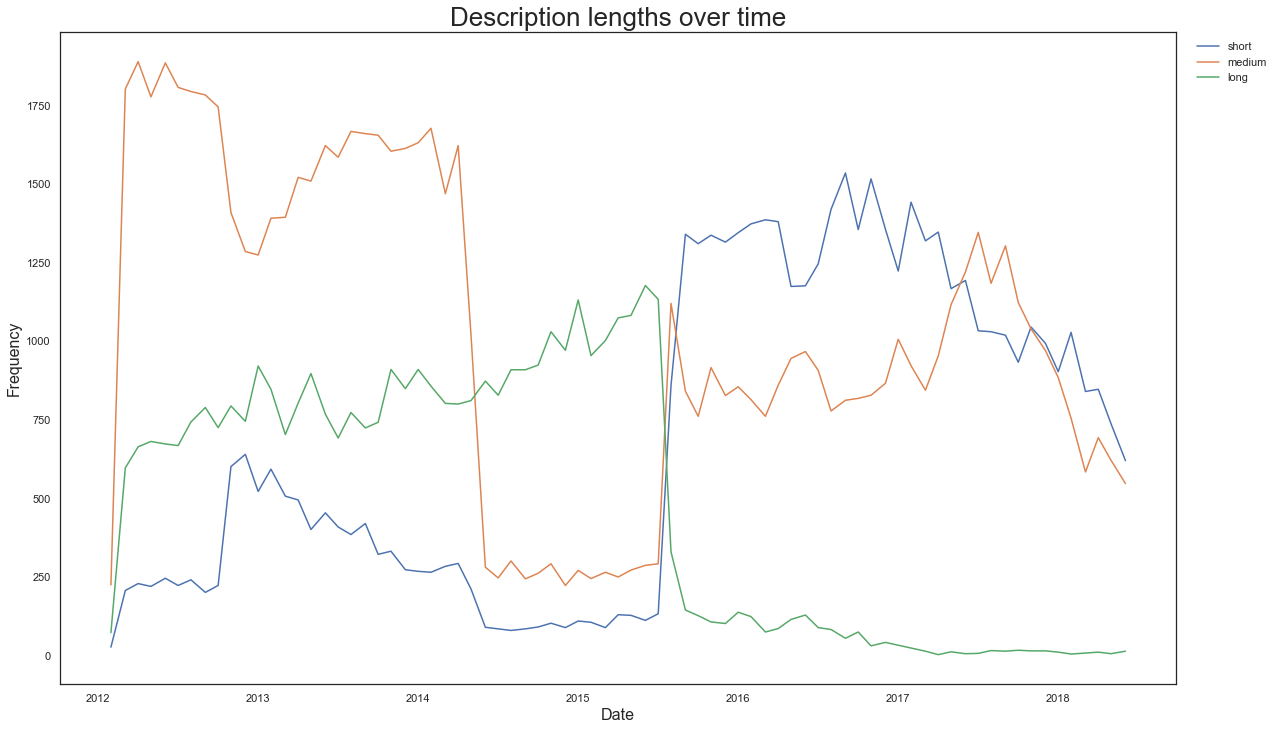

In [37]:
for indices in [first_spike_indices, second_spike_indices, third_spike_indices]:
    spike = sorted(
        Counter(working_copy.loc[indices].year_month).most_common(), key = lambda x: x[0]
    )
    sns.lineplot([count[0] for count in spike], [count[1] for count in spike])

_ = plt.title('Description lengths over time', fontsize = 26);
_ = plt.xlabel('Date', fontsize = 16);
_ = plt.ylabel('Frequency', fontsize = 16);
_ = plt.legend(labels = ['short', 'medium', 'long'], \
               loc = 'upper center', bbox_to_anchor = (1.05, 1));
plt.show();

In [56]:
bad_descriptions = [
    e for e in range(len(description_word_counts)) if description_word_counts[e] < 2
]
share_of_bad_descriptions = len([l for l in description_word_counts if l < 2]) / df.shape[0]
worst_descriptions = Counter(df.loc[bad_descriptions].short_description).most_common()[:2]

print(
    'The share of bad descriptions is about', round(share_of_bad_descriptions * 100, 2), '%.',
    round((worst_descriptions[0][1] + worst_descriptions[1][1]) / len(bad_descriptions) * 100, 2),
    '% of those are either "', worst_descriptions[0][0], '" or "', worst_descriptions[1][0], '".'
)

The share of bad descriptions is about 16.39 %. 96.51 % of those are either "  " or " \ ".


In [57]:
mean_headline_len = np.mean(headline_word_counts)
useful_descriptions_len = [length for length in description_word_counts if length > 1]
mean_description_len = np.mean(useful_descriptions_len)
headline_len_var = np.var(headline_word_counts)
description_len_var = np.var(useful_descriptions_len)
h_d_mean_len_diff = mean_description_len / mean_headline_len
h_d_length_var_diff = description_len_var / headline_len_var

print('The average headline has', round(mean_headline_len, 2), 'words,',
      'the average description has', round(mean_description_len, 2), 'words.')

print('Thus, the average description is about', round(h_d_mean_len_diff, 2),
      'times as long as the average headline in terms of number of words.')

print('\nThe headline lengths have a variance of', round(headline_len_var, 2), 'words,',
      'the description lengths have a variance of', round(description_len_var, 2), '.')

print('Thus, the variance of the description length is about', round(h_d_length_var_diff, 2),
      'times greater than the variance of the headline length.')

The average headline has 9.52 words, the average description has 21.19 words.
Thus, the average description is about 2.23 times as long as the average headline in terms of number of words.

The headline lengths have a variance of 9.65 words, the description lengths have a variance of 173.88 .
Thus, the variance of the description length is about 18.01 times greater than the variance of the headline length.


## 1.2.2 Special Headline Endings

In [58]:
special_endings = [
    h[::-1][1:].split('(')[0][::-1] for h in df.headline.tolist() \
    if len(h) > 0 and h[len(h) - 1] == ')' and h[len(h) - 2].isupper()
]

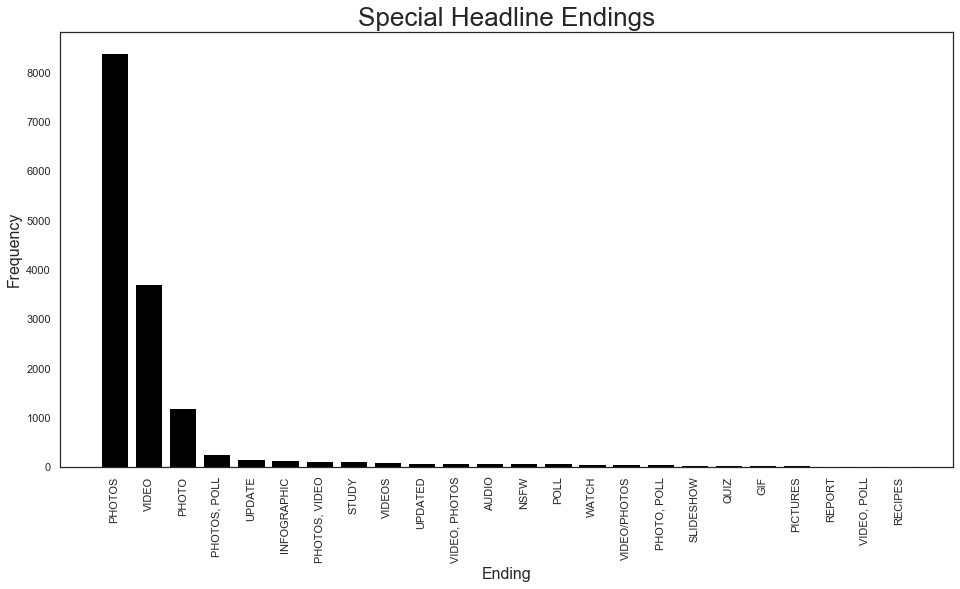

In [59]:
specials_names = [s[0] for s in list(Counter(special_endings).most_common())]
specials_cnt = [s[1] for s in list(Counter(special_endings).most_common())]
specials_names = specials_names[:specials_cnt.index(17) - 1]
specials_cnt = specials_cnt[:specials_cnt.index(17) - 1]

plt.figure(figsize = (16, 8));
plt.bar(specials_names, specials_cnt, color = 'black');
plt.xticks(rotation = 90);
plt.title('Special Headline Endings', fontsize = 26);
plt.xlabel('Ending', fontsize = 16);
plt.ylabel('Frequency', fontsize = 16);